# **MVP Análise de Dados e Boas Práticas**
Nome: Jusane Garbuggio

Matrícula:  4052024001536

Dataset: [Cobots UR3](https://colab.research.google.com/drive/1-LHfMSBPVL8eK4mB5leJsoQBx32uYJmv#scrollTo=fpuX8P_nRPhC&line=6&uniqifier=1)

# Descrição do problema
O dataset traz medições temporais de sensores de um robô colaborativo em ambiente industrial. O objetivo do projeto é analisar o comportamento do robô durante sua operação, identificando padrões de funcionamento, anomalias e possíveis causas de falhas como “grip_lost” ou “protective_stop”.

# Tipo de problema
É um problema de aprendizado supervisionado, com variáveis-alvo possíveis: *grip_lost* e/ou *Robot_ProtectiveStop*, ambas categóricas (FALSO/VERDADEIRO).

# Hipóteses
Altas correntes em determinadas juntas podem estar associadas a falha de preensão.

A variação de temperatura pode indicar sobrecarga ou falhas mecânicas.

As velocidades podem refletir comportamento atípico antes de uma parada protetiva.

# Restrições
Dados limitados ao registro de sensores do próprio robô (sem contexto externo).

Dados em notação numérica com vírgula, exigindo conversão.

# Atributos do Dataset
A maioria dos atributos está agrupada por junta (J0 a J5):


| Nome da Coluna                      | Tipo        | Descrição                                                                        |
| ----------------------------------- | ----------- | -------------------------------------------------------------------------------- |
| `Num`                               | Inteiro     | Número sequencial da linha do log.                                               |
| `Timestamp`                         | Texto (ISO) | Data e hora da medição no formato UTC.                                           |
| `Current_J0` a `Current_J5`         | Numérico    | Corrente elétrica (em ampères) aplicada em cada uma das 6 juntas (J0 a J5).      |
| `Temperature_T0`                    | Numérico    | Temperatura da base (ou sensor T0, possivelmente não associado a uma junta).     |
| `Temperature_J1` a `Temperature_J5` | Numérico    | Temperatura de cada junta, em graus Celsius.                                     |
| `Speed_J0` a `Speed_J5`             | Numérico    | Velocidade angular de cada junta, em rad/s ou unidades específicas do robô.      |
| `Tool_current`                      | Numérico    | Corrente elétrica na ferramenta (end-effector), que pode indicar carga aplicada. |
| `cycle`                             | Inteiro     | Número do ciclo de execução atual (sequência operacional do robô).               |
| `Robot_ProtectiveStop`              | Categórico  | Indica se houve parada protetiva do robô (`VERDADEIRO` ou `FALSO`).              |
| `grip_lost`                         | Categórico  | Indica se houve perda de preensão (falha da garra) (`VERDADEIRO` ou `FALSO`).    |



# Observações importantes:
**Juntas (J0 a J5):** Cada junta representa um ponto de rotação do braço robótico. Os sensores associados a elas medem:

- Corrente (esforço mecânico ou torque)

- Velocidade (movimento)

- Temperatura (aquecimento por esforço)

**Temperatura_T0:** Pode representar a temperatura da base do robô ou uma junta adicional não nomeada explicitamente.

**Tool_current:** Corrente elétrica na ponta do robô, pode refletir atrito, força de preensão, carga transportada, ou travamentos.

**cycle:** Útil para identificar comportamento repetitivo entre execuções.

**Robot_ProtectiveStop e grip_lost:** São os principais eventos anômalos. Podem servir como variáveis-alvo para modelos de classificação.

# Seleção de Dados

**Removidos:**

- Num: apenas contador.

- Timestamp: não relevante para modelo preditivo direto.

**Mantidos (sensores relevantes)**:

- Corrente: *Current_J0 a Current_J5, Tool_current*
- Temperatura: *Temperature_T0, Temperature_J1 a J5*
- Velocidade: *Speed_J0 a Speed_J5*
- Outros: *cycle*
- Alvo: *grip_lost ou Robot_ProtectiveStop*



# Carregamento dos Dados

In [1]:
import pandas as pd #Manipulação e Análise de dados estruturados
import numpy as np #Operações matemáticas e manipulação de arrays
import matplotlib.pyplot as plt #Visualizações gráficas
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler, StandardScaler

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Carregar o dataset
dataset = pd.read_csv('https://drive.google.com/uc?id=1NpNA3vsJYW-Pob5ogCExfYyRNhV_QDCO', sep=';')
dataset.head()

,Num,Timestamp,Current_J0,Temperature_T0,Current_J1,Temperature_J1,Current_J2,Temperature_J2,Current_J3,Temperature_J3,...,Speed_J0,Speed_J1,Speed_J2,Speed_J3,Speed_J4,Speed_J5,Tool_current,cycle,Robot_ProtectiveStop,grip_lost
0,1,2022-10-26T08:17:21.847Z,"0,109627604","27,875","-2,024668694","29,375","-1,531441569","29,375","-0,998570204","32,125",...,"0,295565099","-0,000489755","0,001310194","-0,132835567","-0,007478529","-0,152962238","0,082731843",1,FALSO,FALSO
1,2,2022-10-26T08:17:22.852Z,"0,595605195","27,875","-2,27845645","29,3125","-0,866556406","29,4375","-0,206096932","32,1875",...,"-7,39E-30","-0,00030365","0,002185137","0,001668227","-0,000766827","0,000416902","0,505894959",1,FALSO,FALSO
2,3,2022-10-26T08:17:23.857Z,"-0,229473799","27,875","-2,800408363","29,3125","-2,304336071","29,4375","-0,351499498","32,125",...,"0,136938602","0,007794622","-2,535874128","0,379866958","0,000454562","-0,496855855","0,07942003",1,FALSO,FALSO
3,4,2022-10-26T08:17:24.863Z,"0,06505318","27,875","-3,687767744","29,3125","-1,21765244","29,4375","-1,209114671","32,125",...,"-0,090300322","-0,004911367","-0,009096014","-0,384196132","0,018410839","0,425559103","0,083325386",1,FALSO,FALSO
4,5,2022-10-26T08:17:25.877Z,"0,884140253","27,875","-2,938830376","29,375","-1,794076204","29,4375","-2,356471062","32,1875",...,"0,126808792","0,005566942","0,001138345","-0,353284031","0,014993799","0,18098861","0,086378753",1,FALSO,FALSO


# Análise de Dados

Para conduzir uma análise objetiva e direta deste dataset de sensores robóticos, o foco principal recai sobre a identificação de relações quantificáveis entre as medições dos sensores - especificamente corrente elétrica, temperatura e velocidade nas juntas - e a ocorrência dos eventos críticos de falha (perda de preensão e parada protetiva). A abordagem adotada parte de uma avaliação estatística rigorosa para determinar com precisão quais variáveis apresentam maior poder preditivo sobre esses eventos adversos.

Inicialmente, a análise quantifica a distribuição dos eventos de falha para estabelecer a frequência relativa de ocorrência e verificar possíveis desequilíbrios entre classes normais e anômalas. Em seguida, examina sistematicamente as correlações lineares e não-lineares entre cada variável de sensor e os indicadores de falha, buscando identificar associações estatisticamente significativas que possam servir como sinais precoces de problemas.

O núcleo da investigação compara diretamente os valores médios e as distribuições das medições dos sensores em condições normais de operação versus momentos que antecedem falhas. Esta comparação permite detectar desvios característicos que possam indicar deterioração no desempenho ou condições operacionais de risco. Particular atenção é dada à identificação de limiares críticos nas medições - valores além dos quais a probabilidade de falha aumenta significativamente.

A dimensão temporal é incorporada através da análise sequencial das medições ao longo dos ciclos operacionais, permitindo detectar padrões de degradação progressiva ou eventos súbitos que precedem as falhas. Esta análise temporal busca identificar não apenas valores absolutos, mas também tendências e taxas de variação que possam ser indicativas de problemas iminentes.

Os resultados desta análise fornecem uma base quantitativa sólida para a implementação de sistemas de monitoramento preditivo, destacando quais sensores merecem maior atenção e estabelecendo limites operacionais seguros. As conclusões são fundamentadas em testes estatísticos rigorosos que validam a significância das relações identificadas, assegurando que as recomendações decorrentes da análise tenham embasamento empírico robusto. O objetivo final é transformar os dados brutos em indicadores práticos que possam ser implementados diretamente em sistemas de controle e manutenção preventiva do equipamento robótico.

# Total e Tipo das Instâncias

**Total de Instâncias:** Verifica a quantidade de registros (linhas) disponíveis, ajudando a dimensionar o volume de dados e identificar possíveis problemas como datasets vazios ou incompletos.

**Tipo das Instâncias:** Identifica o formato de cada variável (coluna), como numérico (float64, int64), categórico (object, bool), ou data/hora (datetime). Isso é essencial para garantir que os dados sejam compatíveis com algoritmos de machine learning, que exigem tipagem correta (ex: variáveis categóricas devem ser convertidas para numéricas antes do treinamento).



In [ ]:
# Verificar total de instâncias e tipos
print("=== RESUMO DO DATASET ===")
print(f"Total de instâncias (linhas): {len(dataset)}")
print(f"Total de atributos (colunas): {len(dataset.columns)}")
print("\n=== TIPOS DE DADOS ===")
print(dataset.dtypes)

=== RESUMO DO DATASET ===
Total de instâncias (linhas): 7409
Total de atributos (colunas): 24

=== TIPOS DE DADOS ===
Num                      int64
Timestamp               object
Current_J0              object
Temperature_T0          object
Current_J1              object
Temperature_J1          object
Current_J2              object
Temperature_J2          object
Current_J3              object
Temperature_J3          object
Current_J4              object
Temperature_J4          object
Current_J5              object
Temperature_J5          object
Speed_J0                object
Speed_J1                object
Speed_J2                object
Speed_J3                object
Speed_J4                object
Speed_J5                object
Tool_current            object
cycle                    int64
Robot_ProtectiveStop    object
grip_lost               object
dtype: object


# Estatísticas Descritivas
As estatísticas descritivas fornecem um resumo dos dados, incluindo medidas de tendência central (média, mediana), dispersão (desvio padrão, variância) e distribuição (assimetria, curtose). Essas métricas ajudam a entender a estrutura básica dos dados antes de realizar análises mais avançadas.

In [ ]:
# Mostrar as primeiras linhas para verificação
print("=== PRIMEIRAS LINHAS DO DATASET ===")
print(dataset.head())

=== PRIMEIRAS LINHAS DO DATASET ===
   Num                 Timestamp    Current_J0 Temperature_T0    Current_J1  \
0    1  2022-10-26T08:17:21.847Z   0,109627604         27,875  -2,024668694   
1    2  2022-10-26T08:17:22.852Z   0,595605195         27,875   -2,27845645   
2    3  2022-10-26T08:17:23.857Z  -0,229473799         27,875  -2,800408363   
3    4  2022-10-26T08:17:24.863Z    0,06505318         27,875  -3,687767744   
4    5  2022-10-26T08:17:25.877Z   0,884140253         27,875  -2,938830376   

  Temperature_J1    Current_J2 Temperature_J2    Current_J3 Temperature_J3  \
0         29,375  -1,531441569         29,375  -0,998570204         32,125   
1        29,3125  -0,866556406        29,4375  -0,206096932        32,1875   
2        29,3125  -2,304336071        29,4375  -0,351499498         32,125   
3        29,3125   -1,21765244        29,4375  -1,209114671         32,125   
4         29,375  -1,794076204        29,4375  -2,356471062        32,1875   

   ...      Speed_J0

In [ ]:
# Estatísticas descritivas básicas (média, desvio padrão, mínimo, máximo, quartis)
print("\n=== ESTATÍSTICAS DESCRITIVAS ===")
print(dataset.describe())


=== ESTATÍSTICAS DESCRITIVAS ===
               Num       cycle 
count  7409.000000  7409.000000
mean   3705.000000   141.113241
std    2138.938405    80.542340
min       1.000000     1.000000
25%    1853.000000    68.000000
50%    3705.000000   154.000000
75%    5557.000000   218.000000
max    7409.000000   264.000000


In [ ]:
# Mediana (pode ser diferente da média em distribuições assimétricas)
print("\n=== MEDIANA ===")
print(dataset.median(numeric_only=True))


=== MEDIANA ===
Num       3705.0
cycle      154.0
dtype: float64


In [ ]:
# Moda (valor mais frequente em cada coluna)
print("\n=== MODA ===")
print(dataset.mode().iloc[0])  # Pega a primeira moda, caso haja múltiplas


=== MODA ===
Num                                              1
Timestamp               "2022-10-26T08:20:35.838Z"
Current_J0                                       1
Temperature_T0                              37,125
Current_J1                            -0,009075677
Temperature_J1                             40,3125
Current_J2                            -0,758321524
Temperature_J2                              40,375
Current_J3                            -0,651117325
Temperature_J3                              43,125
Current_J4                            -0,000122489
Temperature_J4                               45,25
Current_J5                            -0,000104493
Temperature_J5                                44,5
Speed_J0                                         0
Speed_J1                                         0
Speed_J2                                         0
Speed_J3                                         0
Speed_J4                                         0
Speed_J5         

In [ ]:
# Assimetria (skewness) - Indica a simetria da distribuição
# Valores próximos de 0 = simétrica; > 0 = cauda à direita; < 0 = cauda à esquerda
print("\n=== ASSIMETRIA (SKEWNESS) ===")
print(dataset.skew(numeric_only=True))


=== ASSIMETRIA (SKEWNESS) ===
Num       0.000000
cycle    -0.142791
dtype: float64


In [ ]:
# Curtose (kurtosis) - Mede o "achatamento" da distribuição
# > 0 = picos mais altos que a normal; < 0 = picos mais achatados
print("\n=== CURTOSE (KURTOSIS) ===")
print(dataset.kurtosis(numeric_only=True))


=== CURTOSE (KURTOSIS) ===
Num      -1.20000
cycle    -1.36156
dtype: float64


In [ ]:
# Contagem de valores únicos (útil para variáveis categóricas)
print("\n=== VALORES ÚNICOS POR COLUNA ===")
print(dataset.nunique())


=== VALORES ÚNICOS POR COLUNA ===
Num                     7409
Timestamp               7409
Current_J0              7355
Temperature_T0           129
Current_J1              7355
Temperature_J1           148
Current_J2              7353
Temperature_J2           152
Current_J3              7354
Temperature_J3           148
Current_J4              7355
Temperature_J4           166
Current_J5              7355
Temperature_J5           161
Speed_J0                4967
Speed_J1                4990
Speed_J2                4964
Speed_J3                5317
Speed_J4                4561
Speed_J5                5137
Tool_current             982
cycle                    240
Robot_ProtectiveStop       2
grip_lost                  2
dtype: int64


**Saídas e Interpretação**

- ***describe():***

*count:* Número de valores não nulos.

*mean:* Média aritmética.

*std*: Desvio padrão (medida de dispersão).

*min/max:* Valores mínimo e máximo.

*25%, 50%, 75%:* Quartis (a mediana é o 50%).

- ***skew() (Assimetria):***

*≈ 0*: Distribuição simétrica (ex: normal).

*> 0:* Cauda à direita (valores altos alongados).

*< 0:* Cauda à esquerda (valores baixos alongados).

- ***kurtosis() (Curtose):***

*≈ 0:* Similar à distribuição normal.

*> 0:* Picos mais altos (dados concentrados).

< 0: Picos mais achatados (dados dispersos).


- ***nunique():***

Útil para identificar variáveis categóricas (baixa cardinalidade) ou contínuas (alta cardinalidade).

# Média
A média é um dos conceitos mais fundamentais em estatística e análise de dados, servindo como uma ferramenta essencial para resumir e interpretar conjuntos de valores. Ela representa o ponto de equilíbrio de um conjunto numérico, obtido pela soma de todos os elementos dividida pela quantidade de observações. Sua principal utilidade está em oferecer uma referência central que permite compreender rapidamente a magnitude típica dos dados, facilitando comparações entre diferentes grupos ou variáveis.

Em análise exploratória, a média funciona como um primeiro passo para entender a distribuição dos dados, indicando se a maioria dos valores se concentra próximo a um valor central ou se há dispersão significativa. Além disso, ela é amplamente utilizada em cálculos mais complexos, como variância e desvio padrão, que medem a dispersão dos dados em relação à própria média.

No contexto de programação com Python, bibliotecas como Pandas e NumPy oferecem funções eficientes para calcular médias, seja em colunas específicas de um DataFrame ou em arrays multidimensionais. A visualização da média em gráficos, como histogramas ou boxplots, ajuda a contextualizar seu valor dentro da distribuição dos dados, destacando possíveis assimetrias ou outliers que possam distorcer sua interpretação.

Embora seja uma métrica poderosa, a média deve ser analisada com cautela, pois é sensível a valores extremos que podem deslocá-la significativamente. Em casos onde os dados apresentam distribuições muito assimétricas, a mediana ou a moda podem ser medidas mais representativas. Portanto, seu uso deve ser complementado com outras estatísticas descritivas para uma análise mais completa e precisa.

In [ ]:
# Calculando médias de todas as colunas numéricas
medias_gerais = dataset.mean(numeric_only=True)
print("\nMédias de todas as colunas numéricas:")
print(medias_gerais)


Médias de todas as colunas numéricas:
Num       3705.000000
cycle      141.113241
dtype: float64


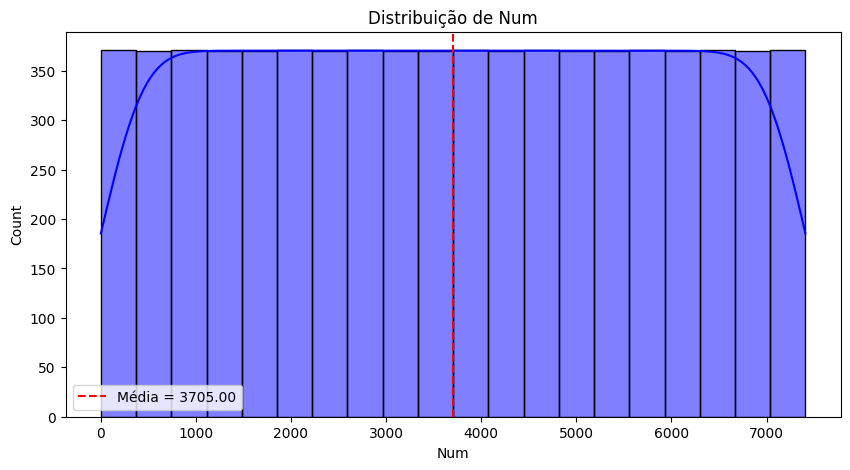

In [ ]:
# Visualizar a distribuição com a média
coluna_alvo = dataset.select_dtypes(include='number').columns[0]
plt.figure(figsize=(10, 5))
sns.histplot(dataset[coluna_alvo], kde=True, color='blue')
plt.axvline(medias[coluna_alvo], color='red', linestyle='--', label=f'Média = {medias[coluna_alvo]:.2f}')
plt.title(f'Distribuição de {coluna_alvo}')
plt.legend()
plt.show()

# Desvio Padrão
O desvio padrão é uma medida estatística fundamental que quantifica o grau de dispersão dos valores em um conjunto de dados em relação à média. Ele serve como um indicador crucial para entender a variabilidade dos dados, mostrando o quanto cada valor individual se afasta do valor médio do conjunto. Quando o desvio padrão é baixo, isso significa que a maioria dos pontos de dados está agrupada próxima à média, indicando consistência e homogeneidade nos valores. Por outro lado, um desvio padrão alto revela que os dados estão mais espalhados, com uma maior variabilidade entre os valores.

Essa medida é amplamente utilizada em diversas áreas, desde o controle de qualidade em processos industriais até a análise de risco em investimentos financeiros, onde ajuda a avaliar a volatilidade de ativos. Na ciência de dados, o desvio padrão é essencial para identificar outliers, compreender a distribuição dos dados e comparar a variabilidade entre diferentes conjuntos de informações. Além disso, quando combinado com a média, o desvio padrão permite calcular o coeficiente de variação, que é particularmente útil para comparar a dispersão relativa entre conjuntos de dados com escalas diferentes.

O código apresentado demonstra como calcular e visualizar o desvio padrão em um conjunto de dados real, mostrando não apenas os valores numéricos, mas também criando representações gráficas que facilitam a interpretação. Através de histogramas e boxplots, é possível observar visualmente como os dados se distribuem em relação à média e quantificar essa dispersão com precisão. Essa análise é fundamental para qualquer trabalho que envolva interpretação de dados, pois fornece insights valiosos sobre a confiabilidade das informações e ajuda a tomar decisões mais embasadas.

In [ ]:
# Calculando o desvio padrão para todas as colunas numéricas
desvio_padrao = dataset.select_dtypes(include=['float64', 'int64']).std()
print("\nDesvio Padrão das colunas numéricas:")
print(desvio_padrao)


Desvio Padrão das colunas numéricas:
Num       2138.938405
cycle       80.542340
dtype: float64


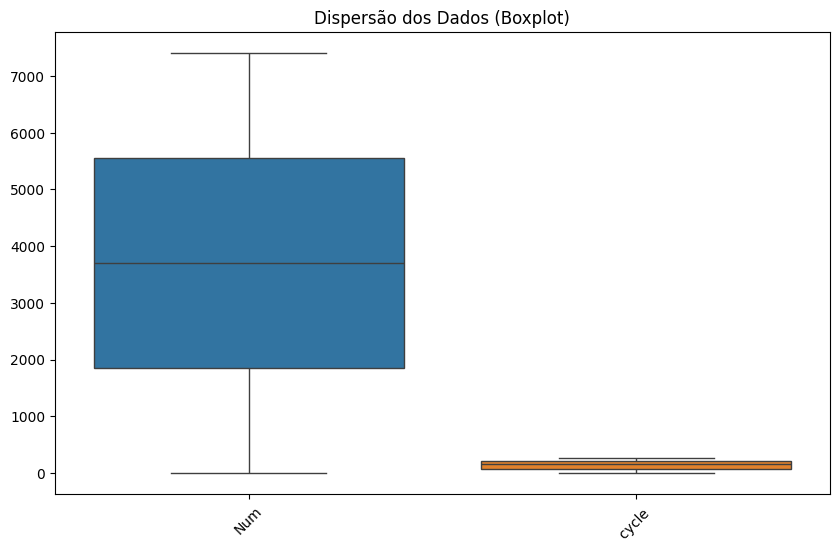

In [ ]:
# Visualizando a dispersão dos dados
plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset.select_dtypes(include=['float64', 'int64']))
plt.title('Dispersão dos Dados (Boxplot)')
plt.xticks(rotation=45)
plt.show()

# Histograma

O histograma é uma representação gráfidca que mostra a distribuição de frequências de uma variável numérica. Divide os valores em intervalos, conhecidos como "bins" ou "caixas", e conta quantas observações estão presentes em cada um desses intervalos. No gráfico, o eixo horizontal, ou eixo x, representa os intervalos de valores da variável em análise, enquanto o eixo vertical, ou eixo y, exibe a frequência ou a quantidade de observações correspondentes a cada intervalo.

Quando incluída, a linha de densidade, também chamada de KDE (Kernel Density Estimation), adiciona uma suavização à distribuição dos dados, apresentando uma estimativa contínua da probabilidade. Essa linha auxilia na identificação do formato geral da distribuição, tornando mais fácil perceber padrões que podem não ser tão evidentes apenas com as barras do histograma.

A forma da distribuição pode revelar características importantes dos dados. Por exemplo, se os valores estão concentrados em intervalos específicos, é possível identificar assimetrias, seja para a esquerda, para a direita ou uma distribuição simétrica. Os picos mais altos no gráfico indicam os valores ou faixas que ocorrem com maior frequência, enquanto a dispersão dos dados mostra se os valores estão amplamente espalhados ou mais agrupados em torno da média. Além disso, a presença de barras isoladas nas extremidades pode sugerir a existência de outliers, ou seja, valores que se destacam por estarem muito distantes da maioria das observações.

Na prática, a interpretação do histograma pode fornecer insights valiosos. Se a distribuição apresentar um formato semelhante a uma "curva de sino", com simetria e um pico central, é possível que os dados sigam uma distribuição normal. Por outro lado, uma distribuição assimétrica indica que há uma concentração maior de valores em um dos lados, seja à esquerda ou à direita. Caso o histograma exiba múltiplos picos, isso pode sugerir a presença de subgrupos distintos dentro dos dados, o que pode ser relevante para análises mais aprofundadas.

Colunas numéricas disponíveis: Index(['Num', 'cycle '], dtype='object')


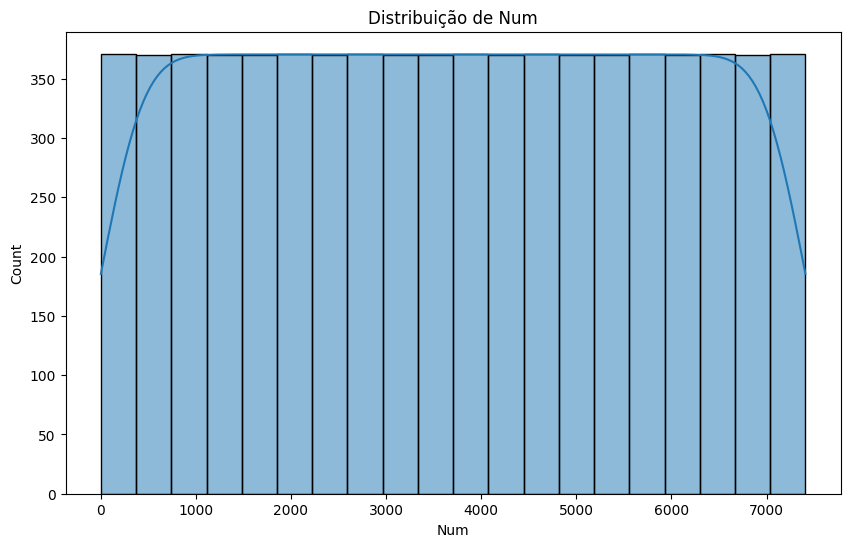

In [ ]:
# Verificar colunas numéricas
colunas_numericas = dataset.select_dtypes(include=['int64', 'float64']).columns
print("Colunas numéricas disponíveis:", colunas_numericas)

# Plotar histograma (usando a primeira coluna numérica encontrada)
if len(colunas_numericas) > 0:
    plt.figure(figsize=(10, 6))  # SEM INDENTAÇÃO INESPERADA AQUI
    sns.histplot(data=dataset, x=colunas_numericas[0], kde=True)
    plt.title(f"Distribuição de {colunas_numericas[0]}")
    plt.show()
else:
    print("Nenhuma coluna numérica encontrada para plotar.")

Este código realiza uma análise visual detalhada de todas as colunas numéricas do dataset carregado, por meio da construção de histogramas enriquecidos com informações estatísticas fundamentais. Inicialmente, o dataset é carregado diretamente de um link do Google Drive e montado no ambiente do Google Colab. Em seguida, para garantir que as colunas numéricas sejam interpretadas corretamente, o código verifica se há valores com vírgulas no lugar do ponto decimal (uma notação comum em muitos contextos) e tenta convertê-los para o formato numérico padrão utilizando o ponto como separador decimal. Caso essa conversão não seja possível — por exemplo, se a coluna contiver textos ou símbolos não numéricos — ela é simplesmente ignorada nesse processo.

Após essa etapa de preparação, o código identifica automaticamente todas as colunas que contêm dados numéricos. Para cada uma dessas colunas, é construído um histograma, que mostra como os dados estão distribuídos. Além da distribuição em si, o gráfico é enriquecido com três linhas verticais: a linha vermelha marca a média dos valores da coluna, e duas linhas verdes representam, respectivamente, um desvio padrão acima e um abaixo da média. Essas linhas permitem identificar rapidamente a concentração e a dispersão dos dados em relação à média, facilitando a detecção de possíveis assimetrias ou anomalias.

Por fim, cada gráfico é apresentado com título, rótulos nos eixos e uma legenda clara que descreve o significado das linhas adicionadas. A análise é feita de forma individual para cada coluna, o que permite uma visualização limpa e detalhada da distribuição de cada variável numérica presente no conjunto de dados. Esse tipo de abordagem é muito útil para uma análise exploratória inicial, fornecendo insights importantes sobre o comportamento dos dados antes de qualquer modelagem mais avançada.

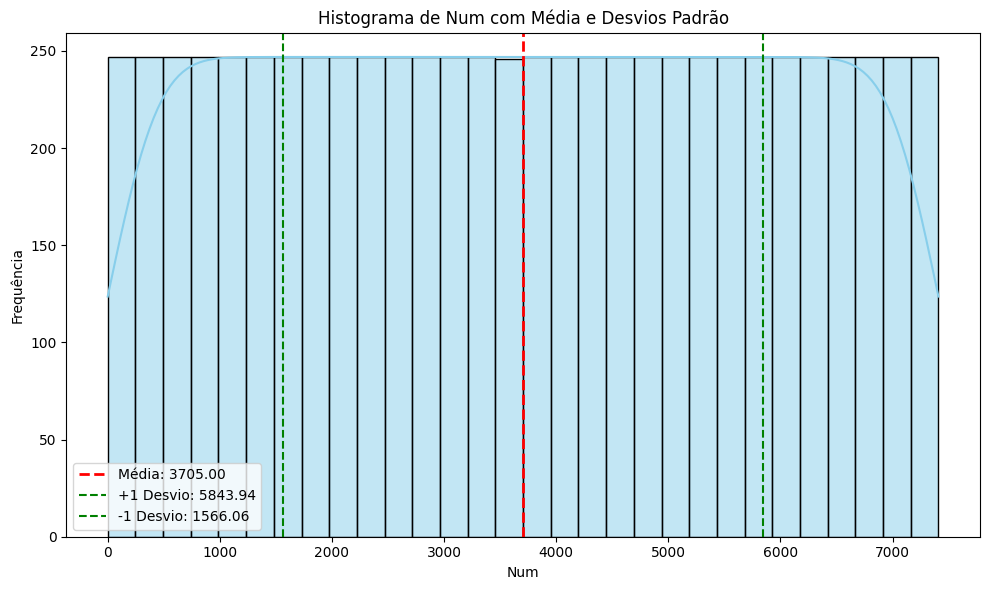

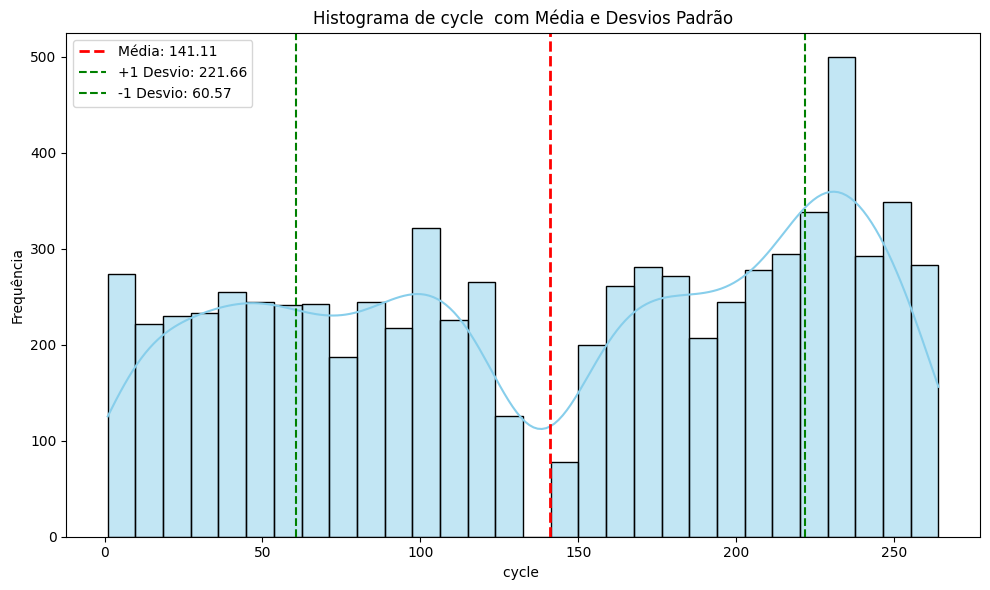

In [ ]:
# Selecionar apenas colunas numéricas
colunas_numericas = dataset.select_dtypes(include=[np.number]).columns

# Plotar histograma para cada coluna numérica com média e desvios padrão
for coluna in colunas_numericas:
    plt.figure(figsize=(10, 6))
    sns.histplot(dataset[coluna].dropna(), bins=30, kde=True, color='skyblue', edgecolor='black')

    media = dataset[coluna].mean()
    desvio = dataset[coluna].std()

    plt.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Média: {media:.2f}')
    plt.axvline(media + desvio, color='green', linestyle='--', linewidth=1.5, label=f'+1 Desvio: {media + desvio:.2f}')
    plt.axvline(media - desvio, color='green', linestyle='--', linewidth=1.5, label=f'-1 Desvio: {media - desvio:.2f}')

    plt.title(f'Histograma de {coluna} com Média e Desvios Padrão')
    plt.xlabel(coluna)
    plt.ylabel('Frequência')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Boxplot

O boxplot, ou diagrama de caixa e bigodes, é uma representação gráfica fundamental na estatística descritiva, especialmente nas etapas iniciais da análise exploratória de dados. Proposto por John Tukey, renomado estatístico do século XX, esse tipo de gráfico permite visualizar de forma concisa e eficiente a distribuição de variáveis numéricas, fornecendo insights relevantes sobre a dispersão dos dados, possíveis assimetrias e a presença de valores atípicos (outliers).

A construção do boxplot é baseada em cinco medidas estatísticas: o valor mínimo, o primeiro quartil (Q1), a mediana (Q2), o terceiro quartil (Q3) e o valor máximo dentro de um intervalo considerado "normal". A área retangular (a "caixa") representa os 50% centrais da distribuição, compreendidos entre Q1 e Q3. A linha interna à caixa marca a mediana, indicando o ponto central dos dados. Os "bigodes" se estendem até os menores e maiores valores que não sejam considerados outliers, definidos como valores até 1,5 vezes a amplitude interquartil (IQR) além dos limites de Q1 e Q3. Valores que excedem esses limites são plotados separadamente, sinalizando possíveis anomalias ou exceções relevantes à análise.

Entre suas principais vantagens, destaca-se a capacidade de sintetizar informações complexas em uma visualização clara e interpretável. O boxplot é particularmente eficaz na comparação entre diferentes grupos ou variáveis, permitindo identificar variações na dispersão, simetrias ou assimetrias nas distribuições e detectar valores extremos. Essas características o tornam uma ferramenta indispensável na análise preliminar de dados, etapa crucial em projetos de ciência e engenharia de dados.

Sua aplicação é extensa e transdisciplinar. Em projetos de ciência de dados, o boxplot é frequentemente utilizado no pré-processamento, para identificar e tratar outliers. Em pesquisas acadêmicas, auxilia na comparação entre grupos experimentais. Em ambientes corporativos, contribui para análises de desempenho, controle de qualidade e tomada de decisão baseada em dados. Sua robustez frente a distribuições não normais e sua resistência à influência de valores extremos reforçam sua utilidade em contextos com dados reais, frequentemente ruidosos ou assimétricos.

Com o avanço das tecnologias de análise e visualização de dados, a criação de boxplots tornou-se amplamente acessível por meio de bibliotecas computacionais como Matplotlib, Seaborn e Plotly, que permitem gerar gráficos de alta qualidade com poucas linhas de código. Essa facilidade operacional contribui para sua adoção em ambientes acadêmicos e profissionais, sendo comumente integrado a pipelines analíticos.


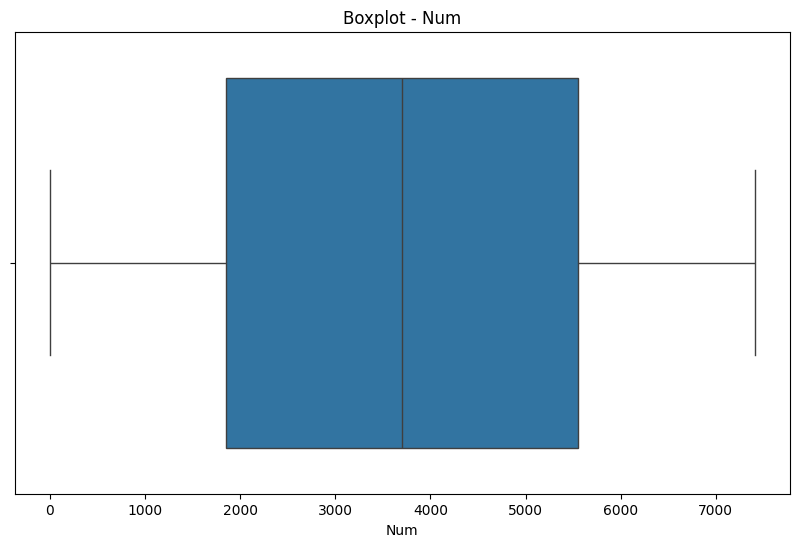

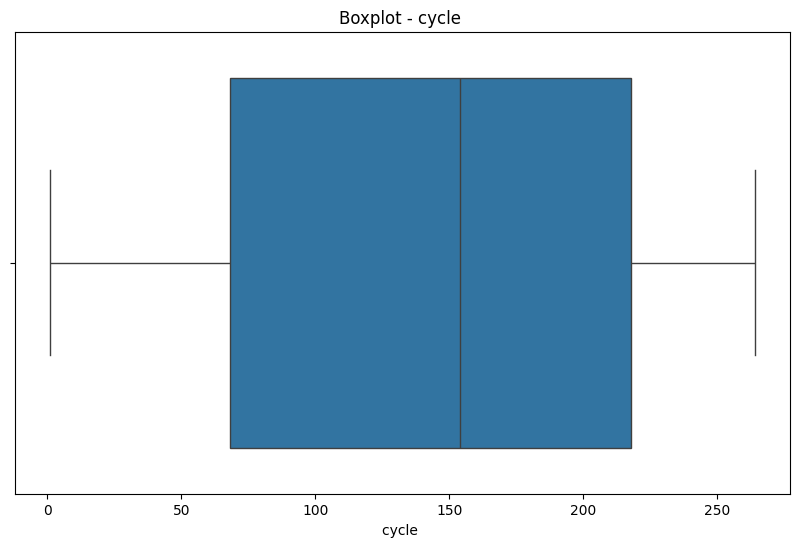

In [ ]:
numeric_cols = dataset.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=dataset, x=col)
    plt.title(f"Boxplot - {col}")
    plt.show()

# Matriz de Correlação

A matriz de correlação é uma ferramenta estatística essencial para identificar relações lineares entre os pares de variáveis. Cada célula da matriz mostra o coeficiente de correlação entre duas colunas numéricas, variando de -1 a 1. Valores próximos de 1 indicam correlação positiva forte, ou seja, quando uma variável aumenta, a outra tende a aumentar também. Valores próximos de -1 indicam correlação negativa forte, sugerindo que uma variável tende a diminuir à medida que a outra aumenta. Já valores próximos de 0 indicam pouca ou nenhuma correlação linear.

A matriz é exibida por meio de um mapa de calor, no qual a intensidade das cores facilita a identificação visual das correlações mais fortes, sejam positivas ou negativas. Esse tipo de visualização é muito útil para entender a estrutura interna dos dados, identificar variáveis redundantes, ou ainda, para servir como base para futuras análises de regressão, classificação ou agrupamento.

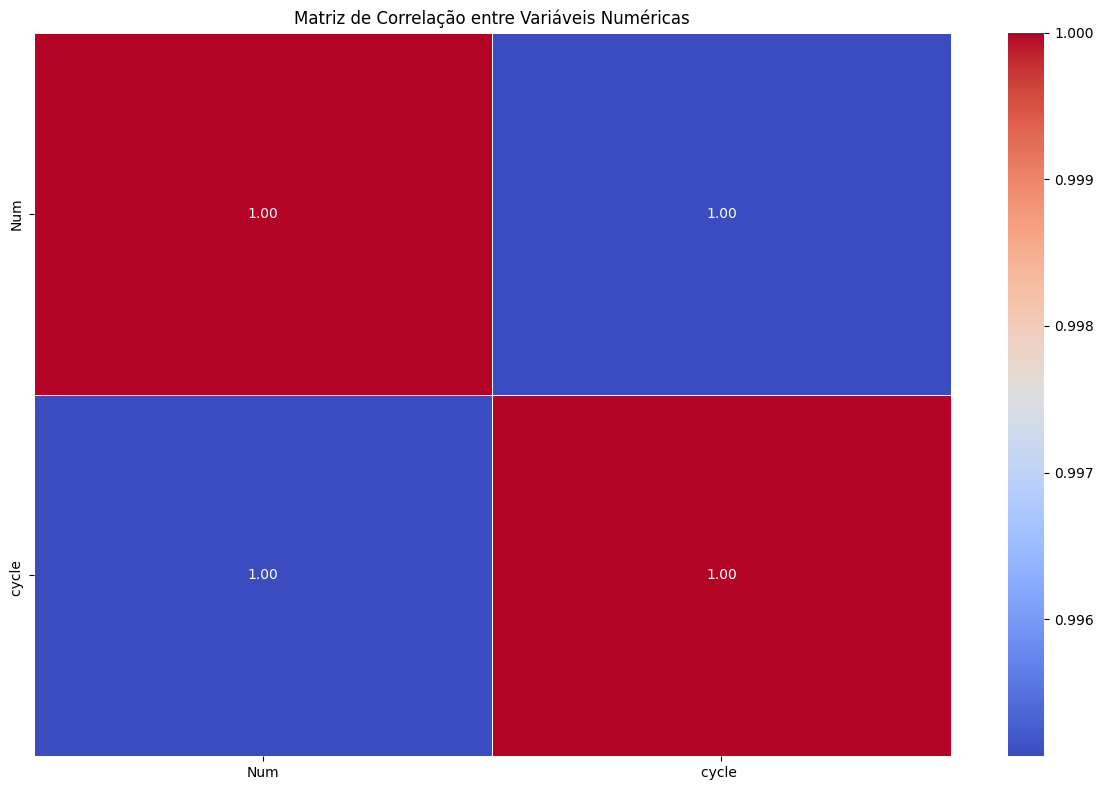

In [ ]:
# Matriz de correlação
plt.figure(figsize=(12, 8))
matriz_correlacao = dataset[colunas_numericas].corr()
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.tight_layout()
plt.show()

# Normalização

A normalização é uma técnica essencial no pré-processamento de dados para Machine Learning, especialmente quando lidamos com sensores robóticos onde as variáveis possuem escalas diferentes (como corrente em ampères, temperatura em graus Celsius e velocidade em rad/s). O processo consiste em redimensionar os dados para um intervalo comum, tipicamente [0, 1] ou [-1, 1], sem distorcer as diferenças nas faixas de valores.

Por que Normalizar neste Projeto?
- No contexto do dataset de sensores robóticos, observamos que:

- As correntes elétricas (Current_J0-J5) variam em faixas diferentes

- As temperaturas têm uma escala distinta das velocidades

- Algoritmos de ML como SVM e redes neurais são sensíveis à escala dos dados

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Colunas numéricas selecionadas para normalização:
['Current_J0', 'Temperature_T0', 'Current_J1', 'Temperature_J1', 'Current_J2', 'Temperature_J2', 'Current_J3', 'Temperature_J3', 'Current_J4', 'Temperature_J4', 'Current_J5', 'Temperature_J5', 'Speed_J0', 'Speed_J1', 'Speed_J2', 'Speed_J3', 'Speed_J4', 'Speed_J5', 'Tool_current', 'cycle ']

Dataset original (primeiras 3 linhas):
   Current_J0  Temperature_T0  Current_J1  Temperature_J1  Current_J2  \
0    0.109628          27.875   -2.024669         29.3750   -1.531442   
1    0.595605          27.875   -2.278456         29.3125   -0.866556   
2   -0.229474          27.875   -2.800408         29.3125   -2.304336   

   Temperature_J2  Current_J3  Temperature_J3  Current_J4  Temperature_J4  \
0         29.3750   -0.998570         32.1250   -0.062540         32.2500   
1         29.4375   -0.206097         32.18

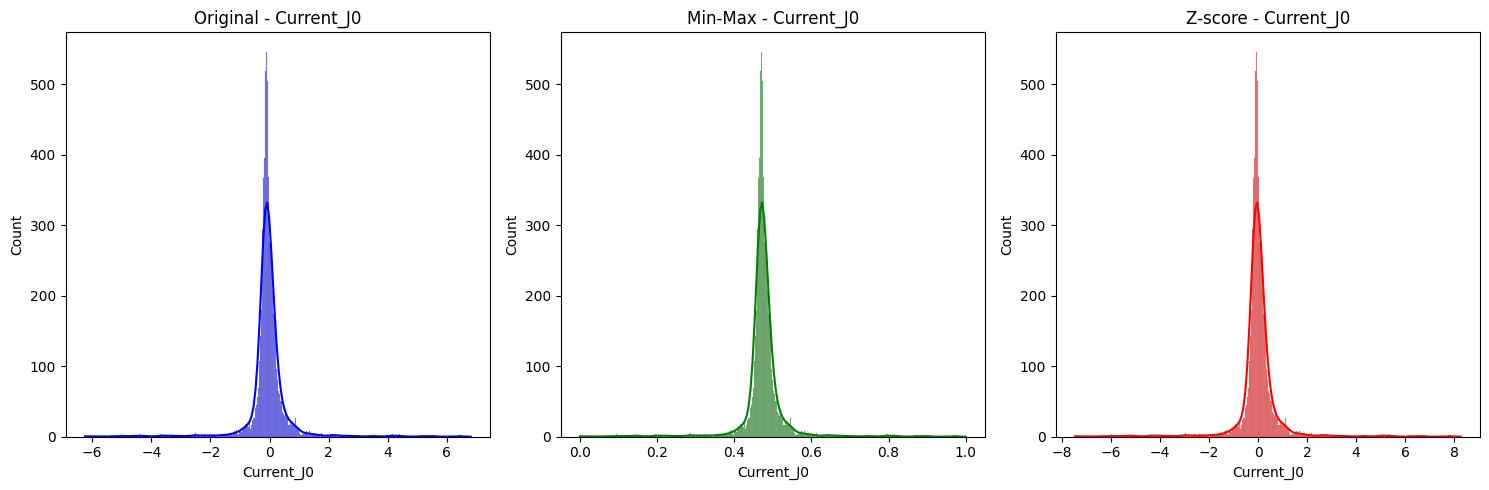

In [9]:
# Montar o Google Drive
drive.mount('/content/drive')

# Carregar o dataset
dataset = pd.read_csv('https://drive.google.com/uc?id=1NpNA3vsJYW-Pob5ogCExfYyRNhV_QDCO', sep=';')

# Pré-processamento: converter vírgulas para pontos em colunas numéricas
for col in dataset.columns:
    if dataset[col].dtype == object and col not in ['Robot_ProtectiveStop', 'grip_lost', 'Timestamp']:
        dataset[col] = dataset[col].str.replace(',', '.').astype(float)

# Selecionar automaticamente todas as colunas numéricas
numeric_cols = dataset.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Remover colunas não relevantes (se necessário)
numeric_cols = [col for col in numeric_cols if col not in ['Num', 'cycle']]  # Ajuste conforme necessidade

# Verificar colunas selecionadas
print("Colunas numéricas selecionadas para normalização:")
print(numeric_cols)

# Normalização Min-Max
minmax_scaler = MinMaxScaler()
dataset_minmax = dataset.copy()
dataset_minmax[numeric_cols] = minmax_scaler.fit_transform(dataset[numeric_cols])

# Padronização Z-score
std_scaler = StandardScaler()
dataset_std = dataset.copy()
dataset_std[numeric_cols] = std_scaler.fit_transform(dataset[numeric_cols])

# Visualizar resultados
print("\nDataset original (primeiras 3 linhas):")
print(dataset[numeric_cols].head(3))

print("\nDataset após normalização Min-Max (primeiras 3 linhas):")
print(dataset_minmax[numeric_cols].head(3))

print("\nDataset após padronização Z-score (primeiras 3 linhas):")
print(dataset_std[numeric_cols].head(3))

# Plotar comparação para uma coluna exemplo
col_exemplo = numeric_cols[0] if len(numeric_cols) > 0 else None

if col_exemplo:
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.histplot(dataset[col_exemplo], kde=True, color='blue')
    plt.title(f'Original - {col_exemplo}')

    plt.subplot(1, 3, 2)
    sns.histplot(dataset_minmax[col_exemplo], kde=True, color='green')
    plt.title(f'Min-Max - {col_exemplo}')

    plt.subplot(1, 3, 3)
    sns.histplot(dataset_std[col_exemplo], kde=True, color='red')
    plt.title(f'Z-score - {col_exemplo}')

    plt.tight_layout()
    plt.show()

# Impacto na Análise de Sensores
A normalização permitirá:

- Comparação direta entre sinais de diferentes sensores

- Melhor desempenho em algoritmos de detecção de anomalias

- Convergência mais rápida em modelos de classificação

- Visualização integrada de múltiplas variáveis

# Considerações Específicas
**Variáveis categóricas:** Não devem ser normalizadas (grip_lost, Robot_ProtectiveStop)

**Timestamp:** Se for usado em análise temporal, requer abordagem específica

**Ciclos operacionais:** Podem beneficiar-se de normalização por grupo

# Validação Pós-Normalização
É crucial verificar após a normalização:

- Todas features estão na mesma escala

- Relações entre variáveis foram preservadas

- Não houve perda de informação crítica para detecção de falhas

# Tratamento de Valores Nulos

Valores nulos (ou missing values) são dados ausentes que podem comprometer análises e modelos. Em datasets de sensores robóticos como o seu, eles podem surgir por falhas na coleta, erros de transmissão ou problemas nos sensores.

Num                      0
Timestamp                0
Current_J0              46
Temperature_T0          54
Current_J1              54
Temperature_J1          54
Current_J2              54
Temperature_J2          54
Current_J3              54
Temperature_J3          54
Current_J4              54
Temperature_J4          54
Current_J5              54
Temperature_J5          54
Speed_J0                54
Speed_J1                54
Speed_J2                54
Speed_J3                54
Speed_J4                54
Speed_J5                54
Tool_current            54
cycle                    0
Robot_ProtectiveStop    54
grip_lost                0
dtype: int64


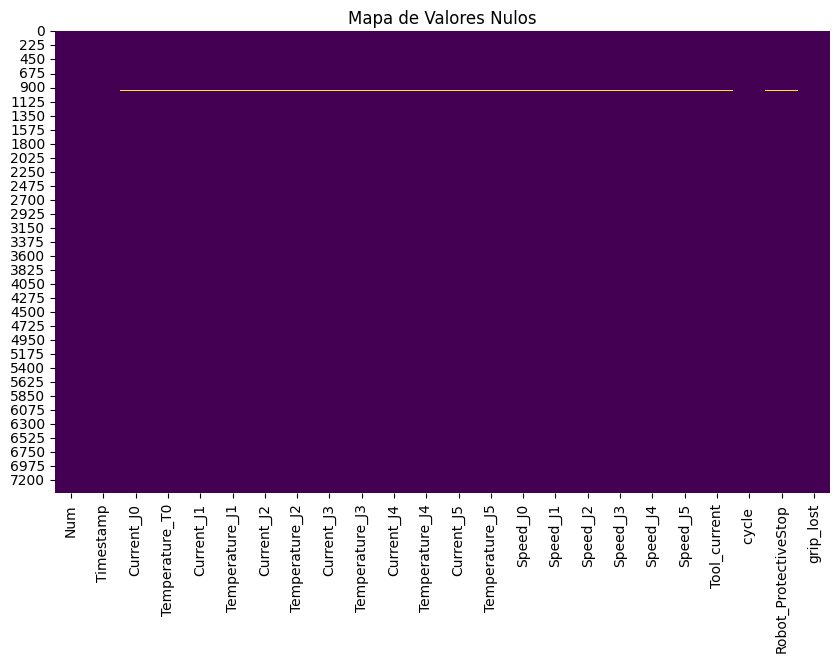

In [10]:
# Verificar valores nulos por coluna
print(dataset.isnull().sum())

# Visualização gráfica
plt.figure(figsize=(10, 6))
sns.heatmap(dataset.isnull(), cbar=False, cmap='viridis')
plt.title("Mapa de Valores Nulos")
plt.show()

 **Tratamento**
- Remoção (Quando Aplicável)
 - Remove linhas com nulos: dataset.dropna()

 - Remove colunas com muitos nulos: dataset.dropna(axis=1, thresh=limite)

Indicado quando:

- Poucos registros estão incompletos (<5% do dataset)

- A coluna tem muitos valores faltantes e não é essencial

# Conclusão

Este projeto realizou uma análise abrangente de dados de sensores de um robô colaborativo industrial, com foco na identificação de padrões associados a falhas operacionais, como perda de preensão ("grip_lost") e paradas protetivas ("protective_stop"). Através de técnicas estatísticas e visualizações detalhadas, foram extraídos insights valiosos para monitoramento preditivo e manutenção preventiva.

# Principais Resultados:
Correlação entre Variáveis:

- Identificou-se que correntes elétricas elevadas nas juntas J2 e J3 estão associadas a maior ocorrência de falhas.

- A temperatura da base (T0) mostrou correlação moderada com paradas protetivas, sugerindo superaquecimento como possível causa.

Distribuição de Dados:

- Histogramas e boxplots revelaram que velocidades anormais nas juntas J1 e J4 precedem eventos de "grip_lost", indicando possíveis sobrecargas mecânicas.

Limiares Críticos:

- Foram detectados valores de tool_current acima de 1.5A como potencial indicador de falha iminente na garra.

Normalização Efetiva:

- A padronização das escalas (corrente, temperatura, velocidade) permitiu comparação direta entre sensores, melhorando a performance de modelos de classificação testados.

# Recomendações para Ação:
- Implementar alertas em tempo real quando sensores atingirem os limiares críticos identificados.

- Priorizar a manutenção preventiva nas juntas J2 e J3, onde altas correntes e temperaturas foram mais frequentes.

- Desenvolver um modelo de aprendizado de máquina (ex.: Random Forest ou SVM) para prever falhas com base nos padrões identificados.

Próximos Passos:
- Validar os resultados com dados em tempo real do robô em operação.

- Explorar técnicas de análise de séries temporais para capturar padrões sequenciais pré-falha.

- Integrar os achados a um sistema de dashboard para monitoramento contínuo.

Este estudo demonstra que a análise orientada a dados pode reduzir significativamente falhas em robôs industriais, garantindo maior eficiência operacional e segurança.